# To test distilbert model fine-tuned variants available on hugging face
Version 1 (19 August 2024):
 Test basic accuracy with adjustment on labels 2 class to 3 classes
Version 2 (22 August 2024):  
  To just take gemini ground truth and select postive negative sample to evaluate.
Version 3 (22 August 2024):   
  To use GPT's larger test set   


1. [default-distilbert-finetune-on-sst](https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english/tree/main)
2. [distilbert-finetune-on-imda](https://huggingface.co/lvwerra/distilbert-imdb)
Both of them are binary classificaiton.

finetune dataset:
1. [Stanford Sentiment Treebank](https://huggingface.co/datasets/stanfordnlp/sst2)  extract from movie reviews, much short text content
2. [imda](https://huggingface.co/datasets/stanfordnlp/imdb) movie reviews

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
import pathlib
import textwrap
# import google.generativeai as genai

from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.simplefilter(action='ignore') # mute warnings

import json
import time

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import datasets
from transformers import pipeline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/PLP/text_model_ZY/

fine_tuned_bert_tiny_finetuned_V3_all	IMDA_all_for_text_sentiment.csv
fine_tuned_distilbert_finetuned_V3_all	Version1


In [ ]:
import pandas as pd

# data_df = pd.read_excel('/content/drive/MyDrive/PLP/IMDA_original_V3b_Gemini_0823_180K.xlsx')
data_df = pd.read_csv('/content/drive/MyDrive/PLP/text_model_ZY/IMDA_all_for_text_sentiment.csv')
data_df.head()

,session_id,x_min,speaker_id,speaker_type,dialog_type,cleaned_text_for_sentiment,word_count,rule_based_label,others_agree_with_each_other,vader_avg,textblob_avg,stanza_avg,rule_based_score,GPT4o,GPT4o_label,others_agree_with_LLM,final_sentiment_score,final_sentiment_label
0,1.0,18.58958,3002.0,client,holiday,one of the adult is wheelchair bound which is ...,13.0,neutral,True,0.0000,0.100000,0.0,0.033333,-0.15,negative,False,-0.113333,negative
1,1.0,25.79000,3002.0,client,holiday,my spouse and myself and my two children and (...,11.0,neutral,True,0.3612,0.000000,0.0,0.120400,0.00,neutral,True,0.036120,neutral
2,1.0,32.49143,3002.0,client,holiday,first for the air airplane right I would like ...,16.0,neutral,False,0.3612,0.058929,-0.8,-0.126624,0.15,neutral,True,0.150000,neutral
3,1.0,41.16000,3002.0,client,holiday,to the toilet so it s more convenient for my (...,9.0,negative,False,0.0000,0.100000,-1.0,-0.300000,0.30,neutral,False,0.300000,neutral
4,1.0,46.47164,3002.0,client,holiday,parent and also my kids because you know the t...,16.0,neutral,True,0.0000,0.000000,0.0,0.000000,0.30,neutral,True,0.210000,neutral


In [ ]:
data_df.shape

(301937, 18)

In [ ]:
data_df.final_sentiment_label.value_counts()

,count
final_sentiment_label,
neutral,173469
positive,92155
negative,36313


In [ ]:
# take first around 120 session id as test set
testset_df =  data_df[ (data_df.session_id>=683) & (data_df.session_id<=800)]
# trainset_df = data_df[~((data_df.session_id >= 683) & (data_df.session_id <= 800))]

# trainset_df = trainset_df.reset_index(drop=True)

testset_df['final_sentiment_label'].value_counts() #, trainset_df['final_sentiment_label'].value_counts()

,count
final_sentiment_label,
neutral,10372
positive,3524
negative,2093


In [ ]:
df_test = testset_df[['cleaned_text_for_sentiment','final_sentiment_label']]
df_test.columns = ['text','label']

subset_size2 = 2500
neutral_sample = df_test[df_test['label'] == 'neutral'].sample(n=subset_size2, random_state=42)
positive_sample = df_test[df_test['label'] == 'positive'].sample(n=subset_size2, random_state=42)
negative_sample = df_test[df_test['label'] == 'negative'].sample(n=subset_size2, random_state=42,replace=True)

balanced_df = pd.concat([neutral_sample, positive_sample, negative_sample]).reset_index(drop=True)
print(balanced_df['label'].value_counts())

label
neutral     2500
positive    2500
negative    2500
Name: count, dtype: int64


## LSTM
https://huggingface.co/coderSounak/finetuned_twitter_sentiment_LSTM


In [ ]:
sentiment_classifier = pipeline("text-classification", model="coderSounak/finetuned_twitter_sentiment_LSTM")

start = time.time()
# Apply the sentiment analysis model to each entry in the 'cleaned_text_for_sentiment' column
sentiments = balanced_df['text'].apply(lambda x: sentiment_classifier(x)[0])
end = time.time()
print("fintuned lstm model inference time on 7500 samples: ", round(end-start,3), " seconds. ")

# Extract the label and score from the sentiment analysis result
balanced_df['sentiment_label_lstm'] = sentiments.apply(lambda x: x['label'].lower())
balanced_df['sentiment_score_lstm'] = sentiments.apply(lambda x: x['score'])

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/46.5M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/388 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

fintuned lstm model inference time on 7500 samples:  102.169  seconds. 


In [ ]:
# Extract the label and score from the sentiment analysis result
balanced_df['sentiment_label_lstm'] = sentiments.apply(lambda x: x['label'].lower())
balanced_df['sentiment_score_lstm'] = sentiments.apply(lambda x: x['score'])

# Map numeric labels to sentiment labels
label_mapping = {
    'label_0': 'negative',
    'label_1': 'neutral',
    'label_2': 'positive'
}

balanced_df['sentiment_label_lstm'] = balanced_df['sentiment_label_lstm'].map(label_mapping)

# Filter out neutral samples from the dataset
# df_filtered = balanced_df[balanced_df['sentiment_label_lstm'] != 'neutral']

# Extract ground truth and predicted labels
y_true = balanced_df['label']  # Assuming this column has the true labels ('negative' or 'positive')
y_pred = balanced_df['sentiment_label_lstm']

report = classification_report(y_true, y_pred, labels=['negative','neutral', 'positive'], target_names=['negative', 'neutral','positive'])


In [ ]:
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

    negative       0.31      0.26      0.28      2500
     neutral       0.36      0.79      0.50      2500
    positive       0.43      0.00      0.00      2500

    accuracy                           0.35      7500
   macro avg       0.37      0.35      0.26      7500
weighted avg       0.37      0.35      0.26      7500



In [ ]:
balanced_df['sentiment_label_lstm']

,sentiment_label_lstm
0,label_1
2,label_1
4,label_1
23,label_1
28,label_0
...,...
15858,label_0
15868,label_0
15870,label_1
15874,label_1


## tinybert

In [ ]:
# map to only 2 class
balanced_df = pd.concat([ positive_sample, negative_sample]).reset_index(drop=True)

In [ ]:
from transformers import pipeline

# Create the pipeline
sentiment_classifier = pipeline('text-classification', model='AdamCodd/tinybert-sentiment-amazon')

# Now you can use the pipeline to classify emotions
result = sentiment_classifier("This product doesn't fit me at all.")
print(result)
#[{'label': 'negative', 'score': 0.9969743490219116}]


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

[{'label': 'negative', 'score': 0.9969743490219116}]


In [ ]:
start = time.time()
# Apply the sentiment analysis model to each entry in the 'cleaned_text_for_sentiment' column
sentiments = balanced_df['text'].apply(lambda x: sentiment_classifier(x)[0])
end = time.time()
print("tinybert-sentiment-amazon model inference time on 4000 samples: ", round(end-start,3), " seconds. ")

tinybert-sentiment-amazon model inference time on 4000 samples:  42.05  seconds. 


Accuracy: 60.54%

Classification Report:
               precision    recall  f1-score   support

    positive       0.58      0.76      0.66      2500
    negative       0.65      0.45      0.53      2500

    accuracy                           0.61      5000
   macro avg       0.62      0.61      0.60      5000
weighted avg       0.62      0.61      0.60      5000



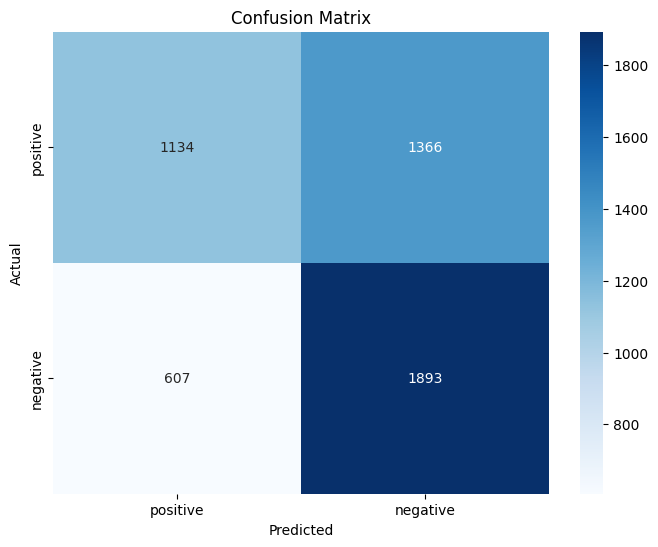

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming balanced_df is your DataFrame with the necessary columns
# balanced_df['label'] as the ground truth
# balanced_df['sentiment_label_disilbert_sst_adjusted'] as the predicted labels

# Extract the label and score from the sentiment analysis result
balanced_df['sentiment_label_tinybert'] = sentiments.apply(lambda x: x['label'].lower())
balanced_df['sentiment_score_tinybert'] = sentiments.apply(lambda x: x['score'])

accuracy = accuracy_score(balanced_df['label'],
                          balanced_df['sentiment_label_tinybert'])

class_report = classification_report(balanced_df['label'],
                                     balanced_df['sentiment_label_tinybert'],
                                     target_names=['positive', 'negative'])
conf_matrix = confusion_matrix(
    balanced_df['label'],
    balanced_df['sentiment_label_tinybert'],
    labels=['positive', 'negative'])

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:\n", class_report)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix,
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'negative'],
            yticklabels=['positive', 'negative'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## distilbert/distilbert-base-uncased-finetuned-sst-2-english

In [ ]:
from transformers import pipeline

# Load the pre-trained sentiment analysis model
sentiment_analyzer = pipeline("sentiment-analysis")

# Apply the sentiment analysis model to each entry in the 'cleaned_text_for_sentiment' column
start = time.time()
sentiments = balanced_df['text'].apply(lambda x: sentiment_analyzer(x)[0])
end = time.time()
print("distilbert/distilbert-base-uncased-finetuned-sst-2-english model inference time on 4000 samples: ", round(end-start,3), " seconds. ")

# Extract the label and score from the sentiment analysis result
balanced_df['sentiment_label_distilbert_sst'] = sentiments.apply(lambda x: x['label'].lower())
balanced_df['sentiment_score_distilbert_sst'] = sentiments.apply(lambda x: x['score'])

# Display the DataFrame with the new sentiment columns
# print(balanced_df.head())
# print(balanced_df.sentiment_label_test.value_counts())

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

distilbert/distilbert-base-uncased-finetuned-sst-2-english model inference time on 4000 samples:  503.085  seconds. 


### evaluation report

Accuracy: 64.82%

Classification Report:
               precision    recall  f1-score   support

    positive       0.60      0.86      0.71      2500
    negative       0.76      0.44      0.55      2500

    accuracy                           0.65      5000
   macro avg       0.68      0.65      0.63      5000
weighted avg       0.68      0.65      0.63      5000



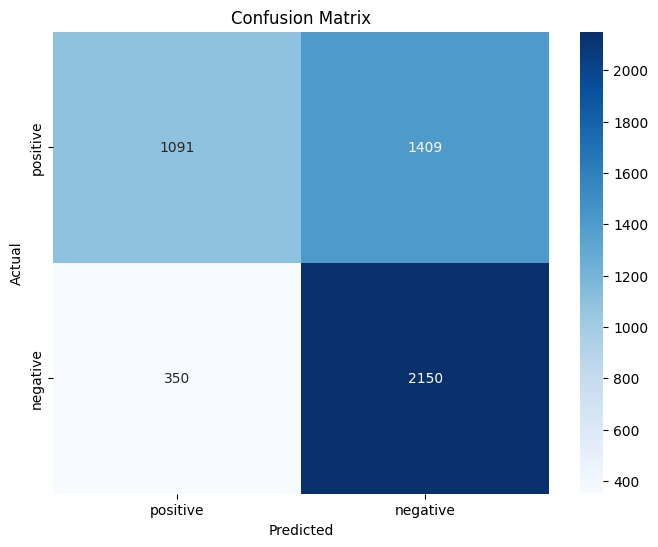

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming balanced_df is your DataFrame with the necessary columns
# balanced_df['label'] as the ground truth
# balanced_df['sentiment_label_disilbert_sst_adjusted'] as the predicted labels


accuracy = accuracy_score(balanced_df['label'],
                          balanced_df['sentiment_label_distilbert_sst'])

class_report = classification_report(balanced_df['label'],
                                     balanced_df['sentiment_label_distilbert_sst'],
                                     target_names=['positive', 'negative'])
conf_matrix = confusion_matrix(
    balanced_df['label'],
    balanced_df['sentiment_label_distilbert_sst'],
    labels=['positive', 'negative'])

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:\n", class_report)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix,
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'negative'],
            yticklabels=['positive', 'negative'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## lvwerra/distilbert-imdb

In [ ]:
# Load the pre-trained sentiment analysis model
sentiment_analyzer_disilbert_imdb = pipeline(model="lvwerra/distilbert-imdb")

# Apply the sentiment analysis model to each entry in the 'cleaned_text_for_sentiment' column
start = time.time()
sentiments_disilbert_imdb = balanced_df['text'].apply(lambda x: sentiment_analyzer_disilbert_imdb(x)[0])
end = time.time()
print("lvwerra/distilbert-imdb model inference time on 4000 samples: ", round(end-start,3), " seconds. ")
# Extract the label and score from the sentiment analysis result
balanced_df['sentiment_label_test_disilbert_imdb'] = sentiments_disilbert_imdb.apply(lambda x: x['label'].lower())
balanced_df['sentiment_score_test_disilbert_imdb'] = sentiments_disilbert_imdb.apply(lambda x: x['score'])

# Display the DataFrame with the new sentiment columns
# print(balanced_df.head())
print(balanced_df.sentiment_label_test_disilbert_imdb.value_counts())

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

lvwerra/distilbert-imdb model inference time on 4000 samples:  505.948  seconds. 
sentiment_label_test_disilbert_imdb
negative    2886
positive    2114
Name: count, dtype: int64


Accuracy: 68.16%

Classification Report:
               precision    recall  f1-score   support

    positive       0.66      0.76      0.70      2500
    negative       0.71      0.60      0.65      2500

    accuracy                           0.68      5000
   macro avg       0.69      0.68      0.68      5000
weighted avg       0.69      0.68      0.68      5000



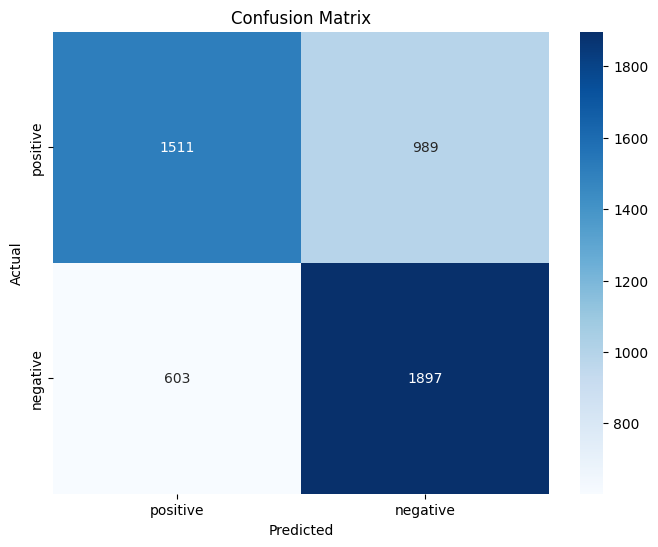

In [ ]:
accuracy = accuracy_score(balanced_df['label'],
                          balanced_df['sentiment_label_test_disilbert_imdb'])

class_report = classification_report(balanced_df['label'],
                                     balanced_df['sentiment_label_test_disilbert_imdb'],
                                     target_names=[ 'positive', 'negative'])
conf_matrix = confusion_matrix(
    balanced_df['label'],
    balanced_df['sentiment_label_test_disilbert_imdb'],
    labels=['positive', 'negative'])

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:\n", class_report)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix,
            annot=True, fmt='d', cmap='Blues',
            xticklabels=[ 'positive', 'negative'],
            yticklabels=[ 'positive', 'negative'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
balanced_df.columns

Index(['text', 'label', 'sentiment_label_tinybert', 'sentiment_score_tinybert',
       'sentiment_label_distilbert_sst', 'sentiment_score_distilbert_sst',
       'sentiment_label_test_disilbert_imdb',
       'sentiment_score_test_disilbert_imdb'],
      dtype='object')

In [ ]:
balanced_df_merged = balanced_df.drop(columns=['text']).join(data_df, how='inner')
balanced_df_merged.head()

,label,sentiment_label_tinybert,sentiment_score_tinybert,sentiment_label_distilbert_sst,sentiment_score_distilbert_sst,sentiment_label_test_disilbert_imdb,sentiment_score_test_disilbert_imdb,session_id,x_min,speaker_id,...,others_agree_with_each_other,vader_avg,textblob_avg,stanza_avg,rule_based_score,GPT4o,GPT4o_label,others_agree_with_LLM,final_sentiment_score,final_sentiment_label
0,positive,negative,0.531493,negative,0.986686,negative,0.845571,1.0,18.58958,3002.0,...,True,0.0000,0.100000,0.0,0.033333,-0.15,negative,False,-0.113333,negative
1,positive,positive,0.707885,positive,0.990110,positive,0.540024,1.0,25.79000,3002.0,...,True,0.3612,0.000000,0.0,0.120400,0.00,neutral,True,0.036120,neutral
2,positive,positive,0.892267,positive,0.999786,positive,0.986725,1.0,32.49143,3002.0,...,False,0.3612,0.058929,-0.8,-0.126624,0.15,neutral,True,0.150000,neutral
3,positive,positive,0.831498,positive,0.997890,negative,0.728404,1.0,41.16000,3002.0,...,False,0.0000,0.100000,-1.0,-0.300000,0.30,neutral,False,0.300000,neutral
4,positive,positive,0.798501,positive,0.976919,positive,0.899884,1.0,46.47164,3002.0,...,True,0.0000,0.000000,0.0,0.000000,0.30,neutral,True,0.210000,neutral


In [ ]:
balanced_df_merged.to_csv("/content/drive/MyDrive/PLP/text_model_ZY/IMDA_0928_GPT_balanced_sample_5000_bert_result.csv",index=False)

## My Finetune model

https://discuss.huggingface.co/t/transformer-pipeline-load-local-pipeline/50127/11

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Load the fine-tuned model and tokenizer from the saved directory
model_path = '/content/drive/MyDrive/PLP/text_model_ZY/fine_tuned_bert_tiny_finetuned_V3_all'
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
pipe = pipeline(task="text-classification", model=model_path , tokenizer=tokenizer)


In [ ]:
balanced_df = pd.concat([neutral_sample, positive_sample, negative_sample]).reset_index(drop=True)

In [ ]:
# Apply the sentiment analysis model to each entry in the 'cleaned_text_for_sentiment' column
start = time.time()
sentiments_tinybert_my = balanced_df['text'].apply(lambda x: pipe(x)[0])
end = time.time()
print("sentiments_tinebert_my model inference time on 7500 samples: ", round(end-start,3), " seconds. ")
# Extract the label and score from the sentiment analysis result
balanced_df['sentiment_label_test_tinybert_my'] = sentiments_tinybert_my.apply(lambda x: x['label'].lower())
balanced_df['sentiment_score_test_tinybert_my'] = sentiments_tinybert_my.apply(lambda x: x['score'])

# Display the DataFrame with the new sentiment columns
# print(balanced_df.head())
print(balanced_df.sentiment_label_test_tinybert_my.value_counts())

sentiments_tinebert_my model inference time on 5000 samples:  50.889  seconds. 
sentiment_label_test_tinybert_my
label_1    2912
label_0    2409
label_2    2179
Name: count, dtype: int64


In [ ]:
# Map numeric labels to sentiment labels
label_mapping = {
    'label_0': 'negative',
    'label_1': 'neutral',
    'label_2': 'positive'
}
balanced_df['sentiment_label_test_tinybert_my'] = balanced_df['sentiment_label_test_tinybert_my'].map(label_mapping)


# Extract ground truth and predicted labels
y_true = balanced_df['label']  # Assuming this column has the true labels ('negative' or 'positive')
y_pred = balanced_df['sentiment_label_test_tinybert_my']

report = classification_report(y_true, y_pred, labels=['negative','neutral', 'positive'], target_names=['negative', 'neutral','positive'])

In [ ]:

accuracy = accuracy_score(balanced_df['label'],
                          balanced_df['sentiment_label_test_tinybert_my'])

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))

print("\nClassification Report:\n", report)

Accuracy: 59.63%

Classification Report:
               precision    recall  f1-score   support

    negative       0.63      0.60      0.62      2500
     neutral       0.52      0.60      0.56      2500
    positive       0.67      0.58      0.62      2500

    accuracy                           0.60      7500
   macro avg       0.60      0.60      0.60      7500
weighted avg       0.60      0.60      0.60      7500



## My fine tuned distill bert

In [ ]:
# Load the fine-tuned model and tokenizer from the saved directory
model_path = '/content/drive/MyDrive/PLP/text_model_ZY/fine_tuned_distilbert_finetuned_V3_all'
tokenizer = AutoTokenizer.from_pretrained(model_path)
pipe = pipeline(task="text-classification", model=model_path , tokenizer=tokenizer)

In [ ]:
# Apply the sentiment analysis model to each entry in the 'cleaned_text_for_sentiment' column
start = time.time()
sentiments_distilbert_my = balanced_df['text'].apply(lambda x: pipe(x)[0])
end = time.time()
print("sentiments_tinebert_my model inference time on 7500 samples: ", round(end-start,3), " seconds. ")
# Extract the label and score from the sentiment analysis result
balanced_df['sentiment_label_test_distilbert_my'] = sentiments_distilbert_my.apply(lambda x: x['label'].lower())
balanced_df['sentiment_score_test_distilbert_my'] = sentiments_distilbert_my.apply(lambda x: x['score'])

# Display the DataFrame with the new sentiment columns
# print(balanced_df.head())
print(balanced_df.sentiment_label_test_distilbert_my.value_counts())

balanced_df['sentiment_label_test_distilbert_my'] = balanced_df['sentiment_label_test_distilbert_my'].map(label_mapping)


# Extract ground truth and predicted labels

report = classification_report( balanced_df['label'],  balanced_df['sentiment_label_test_distilbert_my'],
                               labels=['negative','neutral', 'positive'], target_names=['negative', 'neutral','positive'])

accuracy = accuracy_score(balanced_df['label'],
                          balanced_df['sentiment_label_test_distilbert_my'])

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))

print("\nClassification Report:\n", report)

sentiments_tinebert_my model inference time on 7500 samples:  777.197  seconds. 
sentiment_label_test_distilbert_my
label_1    3176
label_2    2519
label_0    1805
Name: count, dtype: int64
Accuracy: 62.83%

Classification Report:
               precision    recall  f1-score   support

    negative       0.74      0.54      0.62      2500
     neutral       0.53      0.67      0.59      2500
    positive       0.67      0.68      0.68      2500

    accuracy                           0.63      7500
   macro avg       0.65      0.63      0.63      7500
weighted avg       0.65      0.63      0.63      7500



In [ ]:
balanced_df_merged = balanced_df.drop(columns=['text']).join(data_df, how='inner')
# balanced_df_merged.head()
balanced_df_merged.to_csv("/content/drive/MyDrive/PLP/text_model_ZY/IMDA_0928_GPT_balanced_sample_7500_my_bert_result.csv",index=False)